In [65]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import get_cmap
import seaborn as sns
import string
import pickle # save data frame (results) in a .pkl file
import pandas as pd
from datetime import datetime
import os, sys
import re

import grakel as gk


sys.path.insert(0, 'C:/Users/ragna/Documents/Ragnar/Code/MMDGraph')
#from importlib import reload
from mmdutils import readfoldertopanda, PlotROCGeneral, plotVaryingBGDEG, findAUC
#reload(readfoldertopanda)
import importlib
importlib.reload(sys.modules['mmdutils'])
from mmdutils import readfoldertopanda, PlotROCGeneral, plotVaryingBGDEG, findAUC
import MMDforGraphs as mg
importlib.reload(sys.modules['MMDforGraphs'])

<module 'MMDforGraphs' from 'C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\\MMDforGraphs.py'>

In [114]:
from importlib import reload  
foo = reload(mg)

n_1 = 20
n_2 = 20
nnode_1 = 60
nnode_2 = 70


bg1 = mg.BinomialGraphs(n_1, nnode_1, k = 5, l = 'degreelabels', fullyConnected = True)
bg2 = mg.BinomialGraphs(n_2, nnode_2, k = 6, l = 'degreelabels', fullyConnected = True)

In [115]:

bg1.Generate()
bg2.Generate()
Gs = bg1.Gs + bg2.Gs

# kernel = [{"name": "multiscale_laplacian"}]
# K = mg.KernelMatrix(graph_list, kernel, False)
graph_list = gk.graph_from_networkx(Gs, node_labels_tag='label')    
# kernel = [{"name": "weisfeiler_lehman", "n_iter": 4}, {"name": "vertex_histogram"}]
# kernel = [{"name": "lovasz_theta", "n_samples":20}]
#kernel = [{"name": "core_framework", "min_core": 1}, {"name":"propagation", 't_max':5, 'w':0.1, 'M':"H"}]
kernel = [{"name": "pyramid_match", "with_labels":True, "d":2, "L":2}] 
# kernel = [{"name":'odd_sth'}]
# kernel = [{"name": "propagation", "t_max": 4, "w":1, "M":'TV'}]
init_kernel = gk.GraphKernel(kernel= kernel, normalize=True, n_jobs= 4)
K = init_kernel.fit_transform(graph_list)
print(np.all(K == 0)) 
print(K)



MMD_functions = [mg.MMD_b, mg.MMD_u]

# initialize bootstrap class, we only want this to be initalized once so that numba njit
# only gets compiled once (at first call)
kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
function_arguments=[dict(n = bg1.n, m = bg2.n ), dict(n = bg1.n, m = bg2.n )]
kernel_hypothesis.Bootstrap(K, function_arguments, B = 1000)
print(kernel_hypothesis.p_values)

False
[[180. 153. 150. ... 150. 153. 162.]
 [153. 180. 141. ... 156. 156. 156.]
 [150. 141. 180. ... 144. 162. 147.]
 ...
 [150. 156. 144. ... 210. 144. 153.]
 [153. 156. 162. ... 144. 210. 168.]
 [162. 156. 147. ... 153. 168. 210.]]
{'MMD_b': 0.0, 'MMD_u': 0.0}


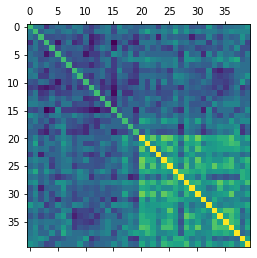

In [116]:
plt.matshow(K)